In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
p_mean = -1.2
p_std=1.2


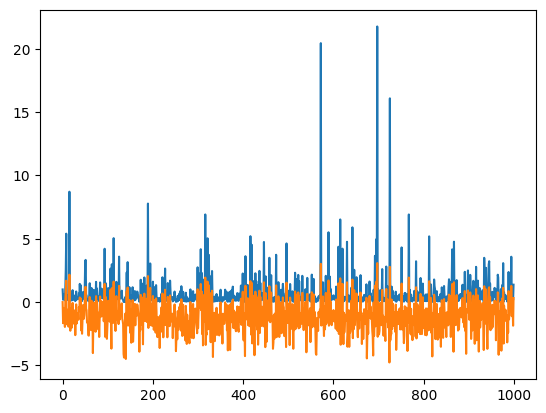

In [26]:
S = []
U=[]
N=1000
for _ in range(N):
    u=p_mean + p_std*torch.randn(1)
    s = torch.exp(u)
    U.append(u)
    S.append(s)
    
fifg = plt.figure()
plt.plot(range(N), S)
plt.plot(range(N), U)

In [27]:
np.exp(max(U)), np.exp(min(U))

(tensor([21.7733]), tensor([0.0085]))

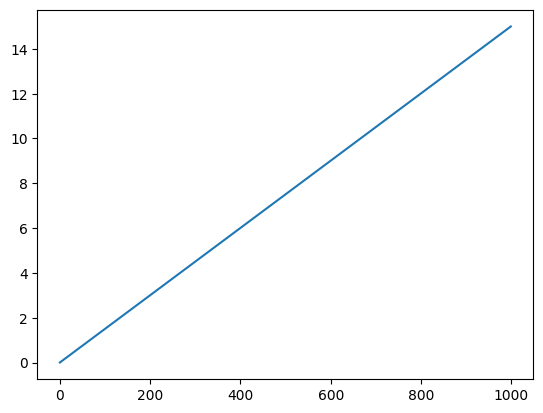

In [20]:
y = np.linspace(0.001, 15, 1000)

plt.plot(range(1000), y)

In [52]:
sigma_max = 80
sigma_min=0.002
rho=7
num_timesteps=100

t=torch.arange(num_timesteps)
const1 = sigma_min**(1/rho) 
const2 = (-sigma_min**(1/rho)+sigma_max**(1/rho))  /(num_timesteps-1)
sigma_ts = (const1 + t * const2)**rho
sigma_ts[0]

tensor(0.0020)

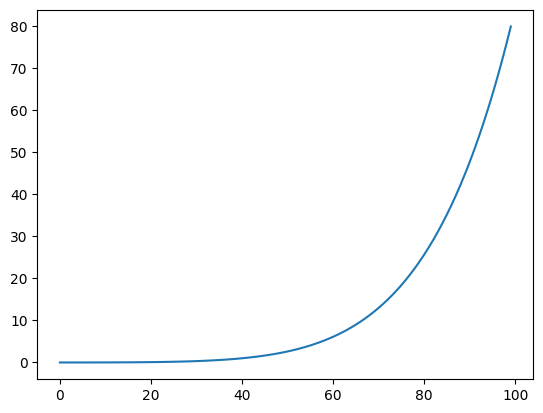

In [53]:
plt.plot(t, sigma_ts)

In [31]:
from distutils.util import strtobool #type: ignore

In [43]:
0.01**(1/2)

0.1

In [44]:
20**(1/2)

4.47213595499958

In [47]:
import torch 
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        
        if self.in_channels!=self.out_channels:
            self.out_channels = self.in_channels
        
        self.input_conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=(1,1))
        self.layers = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=(3, 3), padding=1),
            # nn.BatchNorm2d(self.out_chans),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=(3, 3), padding=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_channels, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_channels, height, width]
        """
        output = input

        return self.layers(output) + self.input_conv(output)


class FullDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels (int): Number of channels in the input.
            out_channels (int): Number of channels in the output.
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.downsample = nn.Sequential(
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=(3, 3), padding=1),
            nn.InstanceNorm2d(self.out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """

        return self.downsample(input)  # self.resblock(self.downsample(input))

    def __repr__(self):
        return f'AvgPool(in_chans={self.in_channels}, out_chans={self.out_channels}\nResBlock(in_chans={self.out_channels}, out_chans={self.out_channels}'


class DiscriminatorModel(nn.Module):
    def __init__(self, im_size=256, in_channels=3, out_channels=2, z_location=None, model_type=None, mbsd=False):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
        """
        super().__init__()

        self.in_channels = in_channels*2
        self.out_channels = out_channels
        self.z_location = z_location
        self.model_type = model_type
        self.mbsd = mbsd
        self.im_size=im_size

        # CHANGE BACK TO 16 FOR MORE
        self.initial_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=(3, 3), padding=1),  # 384x384
            nn.LeakyReLU()
        )

        self.encoder_layers = nn.ModuleList()
        self.encoder_layers += [FullDownBlock(32, 64)]      # im_size/2**1
        self.encoder_layers += [FullDownBlock(64, 128)]     # im_size/2**2
        self.encoder_layers += [FullDownBlock(128, 256)]    # im_size/2**3
        self.encoder_layers += [FullDownBlock(256, 512)]    # im_size/2**4
        self.encoder_layers += [FullDownBlock(512, 512)]    # im_size/2**5

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * int(self.im_size/2**5)**2, 1),
        )

    def forward(self, input, y):
        output = torch.cat([input, y], dim=1)
        output = self.initial_layers(output)

        # Apply down-sampling layers
        for layer in self.encoder_layers:
            output = layer(output)
        return self.dense(output)
        

In [58]:
im_size = 64
x = torch.randn(1,3,im_size, im_size)
y = torch.randn(1,3,im_size, im_size)
D = DiscriminatorModel(in_channels=3, out_channels=2, im_size=im_size)

In [59]:
D(x,x)

torch.Size([1, 512, 2, 2])


tensor([[-0.8181]], grad_fn=<AddmmBackward0>)

In [62]:
sum([p.numel() for p in D.parameters()])

3931297

In [1]:
name = "drftgyuhj_qkv"
target_modules = ["qkv", "proj_out"]
if name.endswith(tuple(target_modules)):
    print("in")
else:
    print("No")

in


# Phase retrieval

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.physics import Ptychography
from deepinv.optim.data_fidelity import L1
from deepinv.optim.phase_retrieval import correct_global_phase

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

In [49]:
import cv2
size = 128
x = cv2.imread("/users/cmk2000/sharedscratch/Datasets/testsets/ffhq/69037.png",0)/255.

x = torch.from_numpy(x[:128,:128]).float().to(device).unsqueeze(0)#.permute(2,0,1)
x.shape

torch.Size([1, 128, 128])

In [50]:
phase = x / x.max() * np.pi  # between 0 and pi
input = torch.exp(1j * phase.to(torch.complex64)).to(device)

img_size = (1, size, size)
n_img = 10**2
probe = dinv.physics.phase_retrieval.build_probe(
    img_size, type="disk", probe_radius=30, device=device
)
shifts = dinv.physics.phase_retrieval.generate_shifts(img_size, n_img=n_img, fov=170)

physics = Ptychography(
    in_shape=img_size,
    probe=probe,
    shifts=shifts,
    device=device,
)

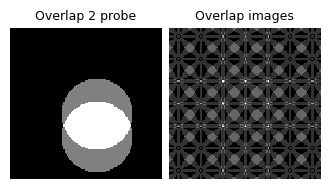

In [51]:
overlap_img = physics.B.get_overlap_img(physics.B.shifts).cpu()
overlap2probe = physics.B.get_overlap_img(physics.B.shifts[55:57]).cpu()
plot(
    [overlap2probe.unsqueeze(0), overlap_img.unsqueeze(0)],
    titles=["Overlap 2 probe", "Overlap images"],
)

torch.Size([1, 128, 128])


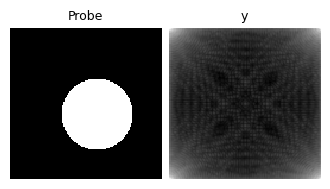

torch.Size([1, 100, 128, 128])

In [52]:
probe = physics.probe[:, 55].cpu()
print(input.shape)
y = physics(input)
plot(
    [torch.abs(probe), y[0].sum(dim=0).log().unsqueeze(0)],
    titles=["Probe", "y"],
)
y.shape

Iter 0, loss: tensor([24974.7148])
Iter 10, loss: tensor([14805.8682])
Iter 20, loss: tensor([11505.7773])
Iter 30, loss: tensor([7639.1567])
Iter 40, loss: tensor([5098.2524])
Iter 50, loss: tensor([3952.6238])
Iter 60, loss: tensor([2956.3171])
Iter 70, loss: tensor([2423.8906])
Iter 80, loss: tensor([2597.0938])
Iter 90, loss: tensor([2759.6680])
Iter 100, loss: tensor([2944.3103])
Iter 110, loss: tensor([2653.5432])
Iter 120, loss: tensor([2952.0730])
Iter 130, loss: tensor([2896.8569])
Iter 140, loss: tensor([2855.1182])
Iter 150, loss: tensor([1817.2329])
Iter 160, loss: tensor([1565.0350])
Iter 170, loss: tensor([1613.8468])
Iter 180, loss: tensor([1503.7842])
Iter 190, loss: tensor([1589.8490])


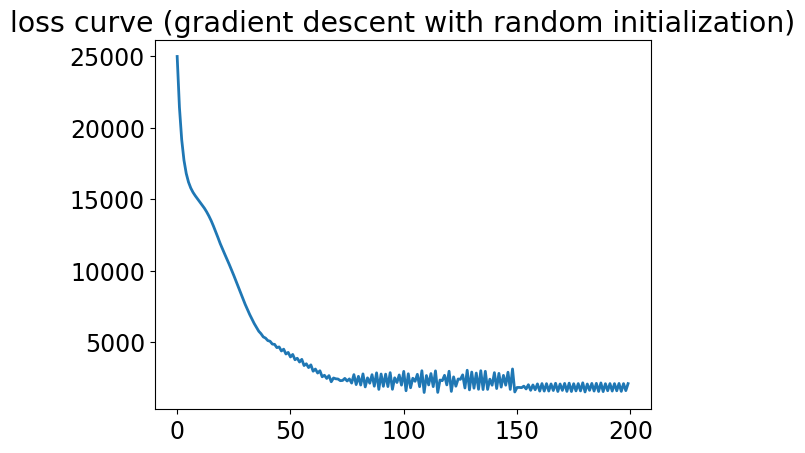

In [53]:
data_fidelity = L1()
lr = 0.1
n_iter = 200
x_est = torch.randn_like(x).to(device).unsqueeze(1)
loss_hist = []

for i in range(n_iter):
    x_est = x_est - lr * data_fidelity.grad(x_est, y, physics)
    loss_hist.append(data_fidelity(x_est, y, physics).cpu())
    if i % 10 == 0:
        print(f"Iter {i}, loss: {loss_hist[i]}")

# Plot the loss curve
plt.plot(loss_hist)
plt.title("loss curve (gradient descent with random initialization)")
plt.show()

torch.Size([1, 1, 128, 128]) torch.Size([1, 128, 128])


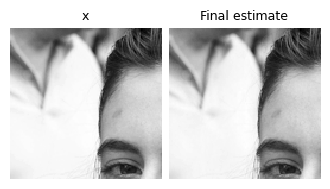

In [56]:
x_est = x_est.detach().cpu()
print(x_est.shape, x.shape)
final_est = correct_global_phase(x_est, x.unsqueeze(0))
plot([x, torch.angle(final_est)], titles=["x", "Final estimate"])

In [43]:
x_est

tensor([[[[nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj],
          [nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj],
          [nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj],
          ...,
          [nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj],
          [nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj],
          [nan+nanj, nan+nanj, nan+nanj,  ..., nan+nanj, nan+nanj, nan+nanj]]]])

In [1]:
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, Zero
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import (
    correct_global_phase,
    cosine_similarity,
    spectral_methods,
)
from deepinv.models.complex import to_complex_denoiser

BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"
# Set global random seed to ensure reproducibility.
torch.manual_seed(0)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [74]:
# Image size
img_size = 32
url = get_image_url("SheppLogan.png")
# The pixel values of the image are in the range [0, 1].
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.min(), x.max(), x.shape, 32*32)

tensor(0.) tensor(0.7412) torch.Size([1, 1, 32, 32]) 1024


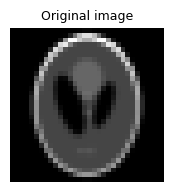

In [59]:
plot(x, titles="Original image")

In [60]:
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [61]:
# Define physics information
oversampling_ratio = 5.0
img_shape = x.shape[1:]
m = int(oversampling_ratio * torch.prod(torch.tensor(img_shape)))
n_channels = 1  # 3 for color images, 1 for gray-scale images

# Create the physics
physics = dinv.physics.RandomPhaseRetrieval(
    m=m,
    img_shape=img_shape,
    device=device,
)

# Generate measurements
y = physics(x_phase)

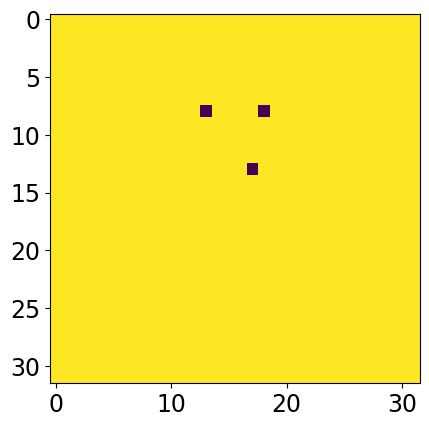

In [81]:
plt.imshow(x_phase.abs()[0,0])

In [62]:
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [63]:
# Define physics information
oversampling_ratio = 5.0
img_shape = x.shape[1:]
m = int(oversampling_ratio * torch.prod(torch.tensor(img_shape)))
n_channels = 1  # 3 for color images, 1 for gray-scale images

# Create the physics
physics = dinv.physics.RandomPhaseRetrieval(
    m=m,
    img_shape=img_shape,
    device=device,
)

# Generate measurements
y = physics(x_phase)

initial loss: tensor([190.4569])
final loss: tensor([28.0710])


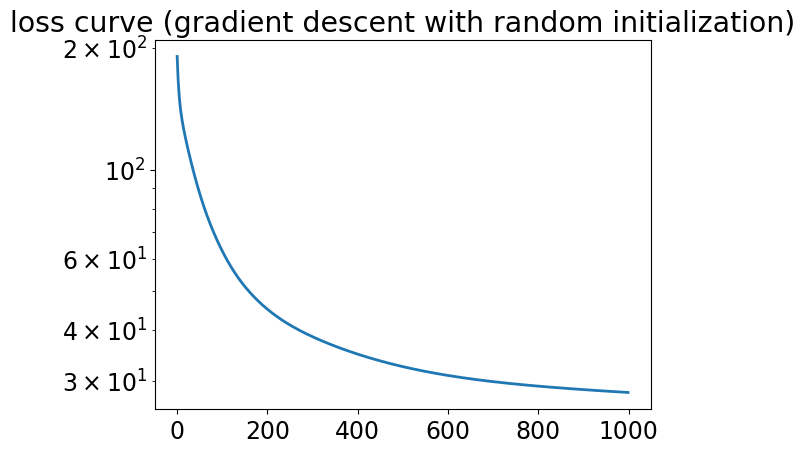

In [64]:
data_fidelity = L2()
prior = Zero()
iterator = dinv.optim.optim_iterators.GDIteration()
# Parameters for the optimizer, including stepsize and regularization coefficient.
optim_params = {"stepsize": 0.06, "lambda": 1.0, "g_param": []}
num_iter = 1000

# Initial guess
x_phase_gd_rand = torch.randn_like(x_phase)

loss_hist = []

for _ in range(num_iter):
    res = iterator(
        {"est": (x_phase_gd_rand,), "cost": 0},
        cur_data_fidelity=data_fidelity,
        cur_prior=prior,
        cur_params=optim_params,
        y=y,
        physics=physics,
    )
    x_phase_gd_rand = res["est"][0]
    loss_hist.append(data_fidelity(x_phase_gd_rand, y, physics).cpu())

print("initial loss:", loss_hist[0])
print("final loss:", loss_hist[-1])
# Plot the loss curve
plt.plot(loss_hist)
plt.yscale("log")
plt.title("loss curve (gradient descent with random initialization)")
plt.show()

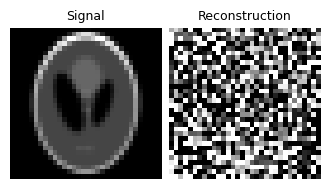

In [65]:
# correct possible global phase shifts
x_gd_rand = correct_global_phase(x_phase_gd_rand, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_rand = torch.angle(x_gd_rand) / torch.pi + 0.5

plot([x, x_gd_rand], titles=["Signal", "Reconstruction"], rescale_mode="clip")

### spectral decomposition

In [66]:
# Spectral methods return a tensor with unit norm.
x_phase_spec = physics.A_dagger(y, n_iter=300)

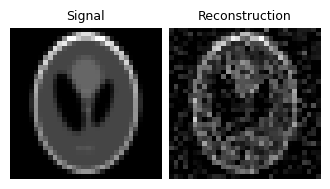

In [67]:
# correct possible global phase shifts
x_spec = correct_global_phase(x_phase_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_spec = torch.angle(x_spec) / torch.pi + 0.5
plot([x, x_spec], titles=["Signal", "Reconstruction"], rescale_mode="clip")

### Gradient descent

intial loss: tensor([42.0413])
final loss: tensor([0.0034])


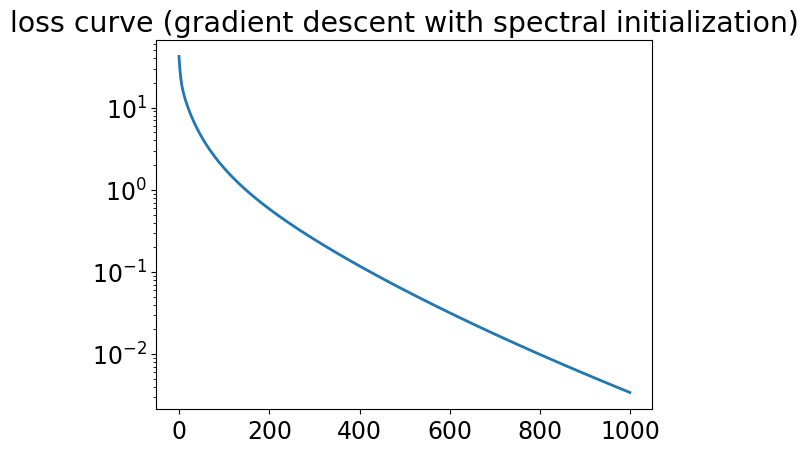

In [68]:
# Initial guess from spectral methods
x_phase_gd_spec = physics.A_dagger(y, n_iter=300)

loss_hist = []
for _ in range(num_iter):
    res = iterator(
        {"est": (x_phase_gd_spec,), "cost": 0},
        cur_data_fidelity=data_fidelity,
        cur_prior=prior,
        cur_params=optim_params,
        y=y,
        physics=physics,
    )
    x_phase_gd_spec = res["est"][0]
    loss_hist.append(data_fidelity(x_phase_gd_spec, y, physics).cpu())

print("intial loss:", loss_hist[0])
print("final loss:", loss_hist[-1])
plt.plot(loss_hist)
plt.yscale("log")
plt.title("loss curve (gradient descent with spectral initialization)")
plt.show()

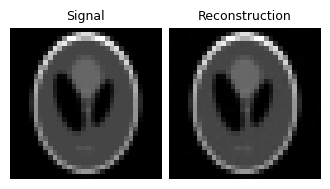

In [69]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec], titles=["Signal", "Reconstruction"], rescale_mode="clip")

### PnP

In [70]:
# Load the pre-trained denoiser
denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    device=device,
)
# The original denoiser is designed for real-valued images, so we need to convert it to a complex-valued denoiser for phase retrieval problems.
denoiser_complex = to_complex_denoiser(denoiser, mode="abs_angle")

# Algorithm parameters
data_fidelity = L2()
prior = PnP(denoiser=denoiser_complex)
params_algo = {"stepsize": 0.30, "g_param": 0.04}
max_iter = 100
early_stop = True
verbose = True

# Instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

# Run the algorithm
x_phase_pnp, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)

Downloading: "https://huggingface.co/deepinv/drunet/resolve/main/drunet_deepinv_gray_finetune_26k.pth?download=true" to /users/cmk2000/.cache/torch/hub/checkpoints/drunet_deepinv_gray_finetune_26k.pth
100%|██████████| 125M/125M [00:07<00:00, 18.6MB/s] 


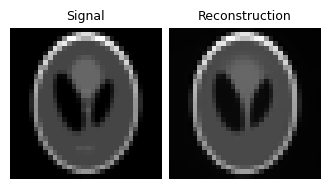

In [71]:
# correct possible global phase shifts
x_pnp = correct_global_phase(x_phase_pnp, x_phase)
# extract phase information and normalize to the range [0, 1]
x_pnp = torch.angle(x_pnp) / (2 * torch.pi) + 0.5
plot([x, x_pnp], titles=["Signal", "Reconstruction"], rescale_mode="clip")

# MRI

In [2]:
import deepinv as dinv
import torch, torchvision

device = dinv.utils.get_freer_gpu if torch.cuda.is_available() else "cpu"
rng = torch.Generator(device=device).manual_seed(0)

100%|██████████| 801k/801k [00:00<00:00, 11.1MB/s]
100%|██████████| 801k/801k [00:00<00:00, 9.51MB/s]


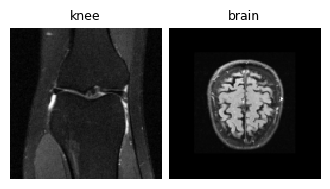

In [83]:
transform = torchvision.transforms.Resize(128)
knee_dataset = dinv.datasets.SimpleFastMRISliceDataset(
    dinv.utils.get_data_home(),
    anatomy="knee",
    transform=transform,
    train=True,
    download=True,
)
brain_dataset = dinv.datasets.SimpleFastMRISliceDataset(
    dinv.utils.get_data_home(),
    anatomy="brain",
    transform=transform,
    train=True,
    download=True,
)

img_size = knee_dataset[0].shape[-2:]  # (128, 128)
dinv.utils.plot({"knee": knee_dataset[0], "brain": brain_dataset[0]})

In [85]:
knee_dataset[0].shape

torch.Size([2, 128, 128])

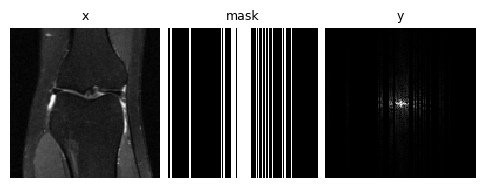

Shapes: torch.Size([1, 2, 128, 128]) torch.Size([1, 2, 128, 128])


In [86]:
physics_generator = dinv.physics.generator.GaussianMaskGenerator(
    img_size=img_size, acceleration=4, rng=rng, device=device
)
mask = physics_generator.step()["mask"]

physics = dinv.physics.MRI(mask=mask, img_size=img_size, device=device)

dinv.utils.plot(
    {
        "x": (x := knee_dataset[0].unsqueeze(0)),
        "mask": mask,
        "y": physics(x).clamp(-1, 1),
    }
)
print("Shapes:", x.shape, physics.mask.shape)

Dataset has been saved at datasets/dinv_dataset0.h5


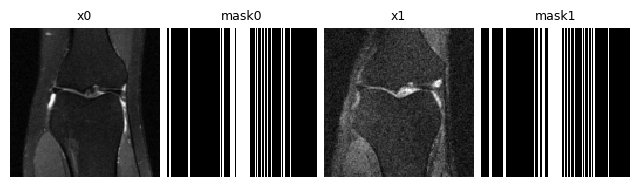

In [87]:
dataset_path = dinv.datasets.generate_dataset(
    train_dataset=knee_dataset,
    test_dataset=brain_dataset,
    val_dataset=None,
    physics=physics,
    physics_generator=physics_generator,
    save_physics_generator_params=True,
    overwrite_existing=False,
    device=device,
    save_dir=dinv.utils.get_data_home(),
    batch_size=1,
)

train_dataset = dinv.datasets.HDF5Dataset(
    dataset_path, split="train", load_physics_generator_params=True
)
test_dataset = dinv.datasets.HDF5Dataset(
    dataset_path, split="test", load_physics_generator_params=True
)

dinv.utils.plot(
    {
        "x0": train_dataset[0][0],
        "mask0": train_dataset[0][2]["mask"],
        "x1": train_dataset[1][0],
        "mask1": train_dataset[1][2]["mask"],
    }
)

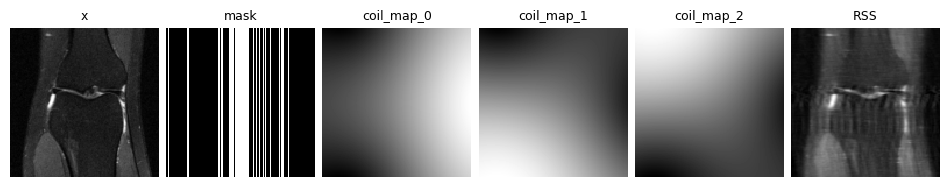

In [88]:
mc_physics = dinv.physics.MultiCoilMRI(img_size=img_size, coil_maps=3, device=device)

dinv.utils.plot(
    {
        "x": x,
        "mask": mask,
        "coil_map_0": mc_physics.coil_maps.abs()[:, 0, ...],
        "coil_map_1": mc_physics.coil_maps.abs()[:, 1, ...],
        "coil_map_2": mc_physics.coil_maps.abs()[:, 2, ...],
        "RSS": mc_physics.A_adjoint_A(x, mask=mask, rss=True),
    }
)

In [32]:
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.utils.demo import load_url_image, get_image_url

In [4]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("CBSD_0010.png")
x = load_url_image(url, grayscale=False).to(device)

x = torch.tensor(x, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size=(64, 64))
img_size = x.shape[1:]
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

/tmp/ipykernel_2449597/3994179018.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float)


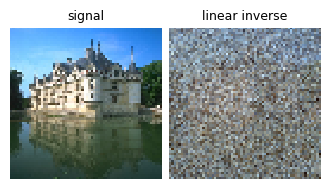

In [5]:
physics = dinv.physics.CompressedSensing(
    m=2048,
    fast=False,
    channelwise=True,
    img_shape=img_size,
    compute_inverse=True,
    device=device,
)

y = physics(x)

# plot results
plot([x, physics.A_dagger(y)], titles=["signal", "linear inverse"])

In [94]:
y.shape

torch.Size([1, 3, 2048])

ValueError: cannot reshape array of size 64 into shape (64,64)

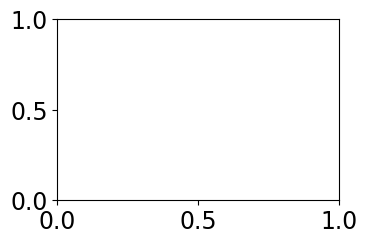

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

# Simulate a 3D image of shape (3, 64, 64)
image = np.zeros((64, 64))
image[30:34, 30:34] = 1  # Simple square in the center

# Function to simulate X-ray projections at different angles
def simulate_ct_observation(image, num_angles=180):
    projections = []
    for angle in range(num_angles):
        projection = radon(image, theta=[angle], circle=True)
        projections.append(projection)
    return np.array(projections)

# Simulate projections for the 2D slice
projections = simulate_ct_observation(image, num_angles=180)

# Display the first few projections
plt.figure(figsize=(8, 8))
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.imshow(projections[i].reshape(64, 64), cmap='gray')
    plt.title(f'Projection at angle {i * 36}')
    plt.axis('off')
plt.show()

# Now let's try to reconstruct the 2D image from projections using back projection
reconstructed_image = iradon(projections.mean(axis=0), theta=np.linspace(0., 180., 180, endpoint=False), circle=True)

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


In [35]:
from deepinv.physics import CompressedSensing
seed = torch.manual_seed(0) # Random seed for reproducibility
x = torch.randn(1, 1, 64,64) # Define random 3x3 image
physics = CompressedSensing(m=10, img_shape=(1, 3, 3), rng=torch.Generator('cpu'))
# physics(x)


In [37]:
# Generate the compressed sensing measurement operator with 10x under-sampling factor.
n_channels=3
img_size = 64
x = torch.randn(3, 64,64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
physics = dinv.physics.CompressedSensing(
    m=78, img_shape=(n_channels, img_size, img_size), fast=True, device=device
)
y = physics(x)

RuntimeError: The size of tensor a (4096) must match the size of tensor b (12288) at non-singleton dimension 1

In [13]:
x.shape

torch.Size([1, 3, 64, 64])

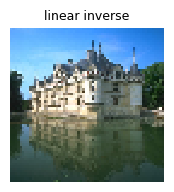

In [12]:
plot([ x], titles=["linear inverse"])

In [43]:
noise_level_img = 0.03  # Gaussian Noise standard deviation for the degradation
angles = 100
n_channels = 3  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.Tomography(
    img_width=img_size,
    angles=angles,
    circle=True,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

PI = 4 * torch.ones(1).atan()
SCALING = (PI / (2 * angles)).to(device)  # approximate operator norm of A^T A

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers = 4 if torch.cuda.is_available() else 0

In [47]:
x = torch.randn(1, 3, 64,64)
x = 2*x-1
y = physics(x)

In [48]:
y.shape

torch.Size([1, 3, 64, 100])

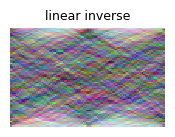

In [49]:
plot([ y], titles=["linear inverse"])

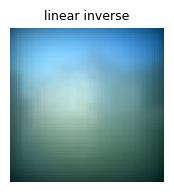

torch.Size([1, 3, 64, 64])

In [32]:
u = physics.A_adjoint(y)*SCALING
plot([ u], titles=["linear inverse"])

u.shape

In [35]:
import requests
import zipfile
import os

def download_large_zip_shared(shared_link, local_path):
    """Download a large ZIP file using a Dropbox shared link."""
    direct_link = shared_link.replace("?dl=0", "?dl=1")  
    with requests.get(direct_link, stream=True) as response:
        response.raise_for_status()
        with open(local_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024): 
                f.write(chunk)
    print(f"Downloaded to {local_path}")

def unzip_file(zip_path, extract_to):
    """Extract a ZIP file and delete it after extraction."""
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to {extract_to}")
    os.remove(zip_path)
    print(f"Deleted {zip_path} after extraction")

# Example Usage
shared_link = "https://www.dropbox.com/scl/fo/ybc183siiymibubwqu00n/AJZo9oNUHZoVxJK9zy5S76Q/training_set.zip?rlkey=l0lz28rinw8b5ozylf1x1tgn0&dl=1"
local_zip_path = "/users/cmk2000/sharedscratch/Datasets/ct_training_set.zip"
extract_folder = "/users/cmk2000/sharedscratch/Datasets/training_CT_data"

# Download the large ZIP file
download_large_zip_shared(shared_link, local_zip_path)

# Unzip it
unzip_file(local_zip_path, extract_folder)


Downloaded to /users/cmk2000/sharedscratch/Datasets/ct_training_set.zip
Extracted files to /users/cmk2000/sharedscratch/Datasets/training_CT_data
Deleted /users/cmk2000/sharedscratch/Datasets/ct_training_set.zip after extraction


In [1]:
import cv2



from PIL import Image

# Load the TIFF image
image = Image.open("/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_0.tif")

# Show the image
image.show()

# Convert to a NumPy array (if needed)
import numpy as np
image_array = np.array(image)


UnidentifiedImageError: cannot identify image file '/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_0.tif'

(320, 320)


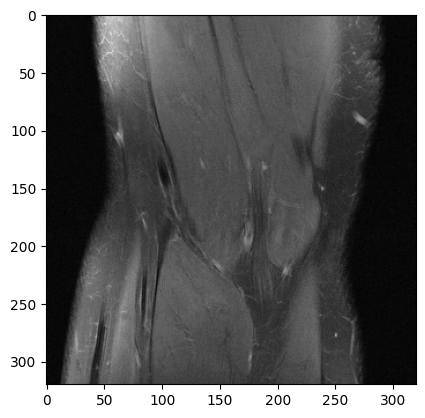

In [2]:
import tifffile as tiff
import matplotlib.pyplot as plt

# Try loading the TIFF file
image = tiff.imread("/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_34.tif")

print(image.shape)  # Check dimensions
plt.imshow(image, cmap="gray")

In [23]:
from PIL import Image
image = Image.open("/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_34.tif")#, mode='r')#.convert('RGB')

UnidentifiedImageError: cannot identify image file '/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_34.tif'

In [3]:
import torch 
from torchvision.transforms import v2


transforms = v2.Compose([
    v2.ToTensor(), 
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trans = transforms(image)

/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
trans.shape

torch.Size([1, 320, 320])

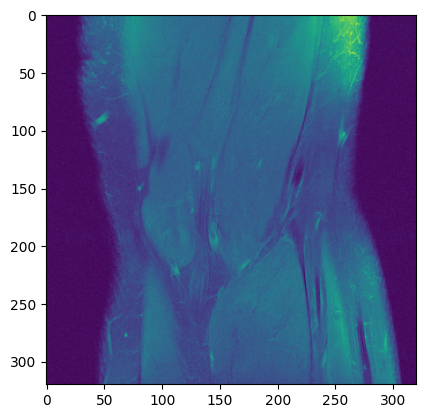

In [5]:
import numpy as np
u = np.uint8(trans.permute(1,2,0)*255)
plt.imshow(u)

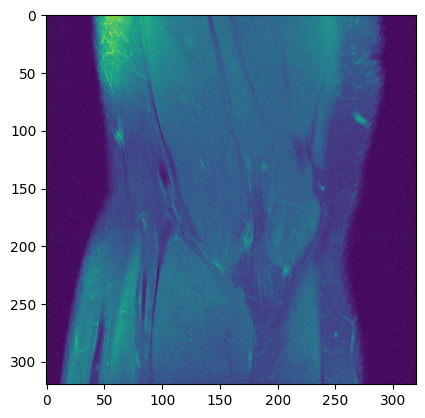

In [19]:
plt.imshow(image)

In [2]:
import numpy as np

np.random.random((5, 1))

array([[0.35453538],
       [0.70190626],
       [0.02290025],
       [0.46099257],
       [0.17858866]])

In [ ]:
import cv2
import numpy as np
pth = "/users/cmk2000/sharedscratch/Datasets/training_CT_data/trainingset_true_tiff/file1000000_34.tif"
# Load grayscale image
image = tiff.imread(pth)

if len(image.shape) == 2:  # Grayscale
    rgb_image = np.stack((image,) * 3, axis=0)  # Duplicate into 3 channels
elif len(image.shape) == 3 and image.shape[-1] == 3:
    rgb_image = image  # Already RGB
else:
    raise ValueError(f"Unexpected image shape: {image.shape}")

print("Converted image shape:", rgb_image.shape)

# tiff.imwrite("wrgb_image.png", image)
print("Saved as 'rgb_image.png'")


colorized_image = cv2.applyColorMap(image.astype("uint8"), cv2.COLORMAP_JET)

# cv2.imwrite("colorized_image.tif", colorized_image)

Converted image shape: (3, 320, 320)
Saved as 'rgb_image.png'


In [9]:
rgb_image.shape

(320, 320, 3)

In [98]:
vv = np.uint8(rgb_image * 255.)
uu = torch.from_numpy(vv).float()/255
print(uu.shape)
transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToTensor(), 
    v2.RandomHorizontalFlip(p=0),
    v2.ToDtype(torch.float32, scale=True),
])


uu = transforms(uu)
# plt.imshow(uu)
uu.max()
uu.shape

torch.Size([3, 320, 320])


/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 256, 256])

In [23]:
xx = np.uint8(rgb_image*255)

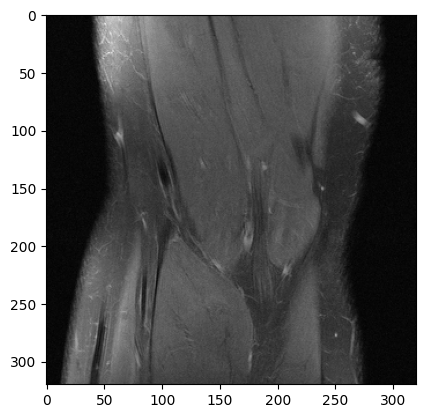

In [24]:
plt.imshow(xx)

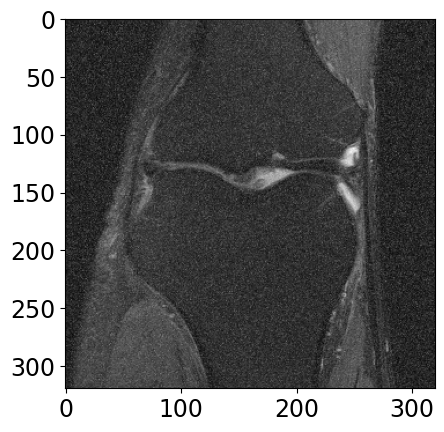

In [72]:
u = tiff.imread("/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/rgb_image.tif")
plt.imshow(u)

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("/users/cmk2000/sharedscratch/CKM/Regularised_CDM/Results/inp_lora/operator_box/28-02-2025/ddim/Max_iter_1/timesteps_10/zeta_0.1/eta_0.0/lambda_0.001/metrics_results/metrics_results.csv")

In [3]:
data.head()

Unnamed: 0  name       psnr       mse      ssim     lpips      time  \
0           0     0  29.869460  0.001031  0.796176  0.102032  2.098934   
1           0     1  28.505875  0.001411  0.833727  0.114779  2.128861   
2           0     2  24.630428  0.003443  0.774704  0.145516  2.000812   
3           0     3  22.325240  0.005854  0.768294  0.138765  2.179873   
4           0     4  27.102812  0.001949  0.816603  0.142759  2.016709   

   psnr last  mse last  ssim last  lpips last  
0  29.869460  0.001031   0.796176    0.102032  
1  28.505875  0.001411   0.833727    0.114779  
2  24.630428  0.003443   0.774704    0.145516  
3  22.325240  0.005854   0.768294    0.138765  
4  27.102812  0.001949   0.816603    0.142759

In [16]:
psnr = data["psnr"]
lpip= data["lpips"]

In [17]:
u = psnr.values
ind = u[u>25]
l = lpip[u>25]
len(ind)

97

In [26]:
ind[:].mean(), l.mean()

(27.435882979381443, 0.11948846963917527)

# SR

In [27]:
data = pd.read_csv("/users/cmk2000/sharedscratch/CKM/Regularised_CDM/Results/sr_lora/operator_gaussian/25-02-2025/ddim/Max_iter_1/timesteps_3/zeta_0.1/eta_0.0/lambda_10.0/metrics_results/metrics_results.csv")

In [28]:
psnr = data["psnr"]
lpip= data["lpips"]

In [36]:
u = psnr.values
ind = u[u>25]
l = lpip[u>25]
len(ind)

108

In [37]:
ind[:].mean(), l.mean()

(26.476402870370368, 0.13441926755555555)

In [1]:
import cv2
import os

im_size = 256
h_pth = "/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/frame_0190.jpg"
im_pth = "/users/cmk2000/sharedscratch/Datasets/testsets/imageffhq/68196.png"
# im_pth = "/users/cmk2000/sharedscratch/Datasets/testsets/imagenet/ILSVRC2012_val_00000007.png"
H = cv2.imread(h_pth)
im = cv2.imread(im_pth)

print(H.shape, im.shape)

(720, 1280, 3) (1024, 1024, 3)


In [24]:
import numpy as np

def save_images(dir, image, name):
    """Save an image to a specified directory with a given name."""
    
    if torch.is_tensor(image):
        image = torch.clamp(image, 0,1)
        image = image*255.
        image = np.uint8(image)
    image_array = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(dir, name + '.png'), image_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0028873151..0.9475106].


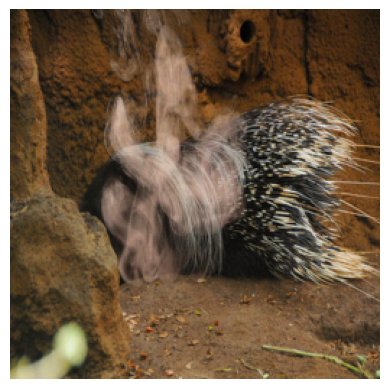

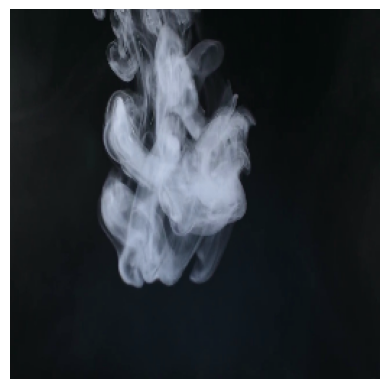

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00018110126..0.94458133].


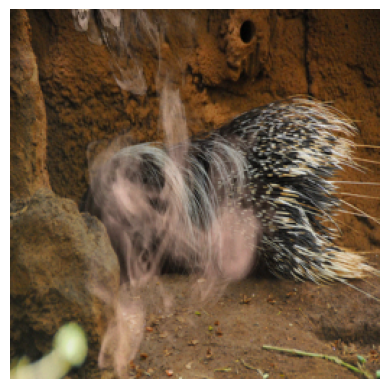

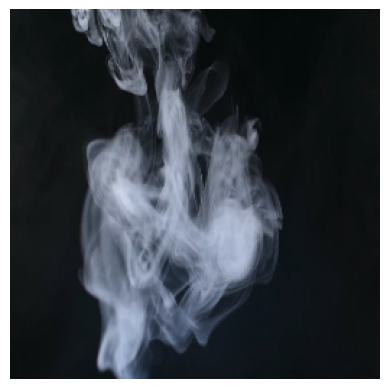

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010776189..0.94046974].


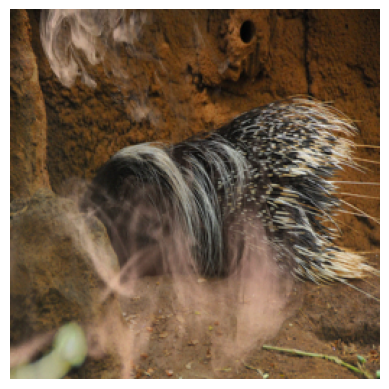

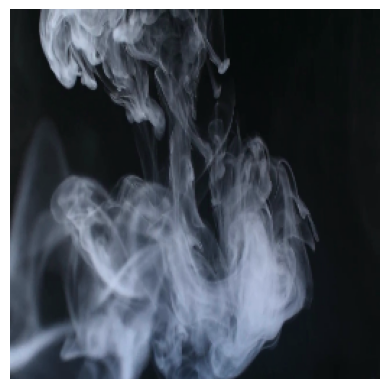

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012282738..0.9447761].


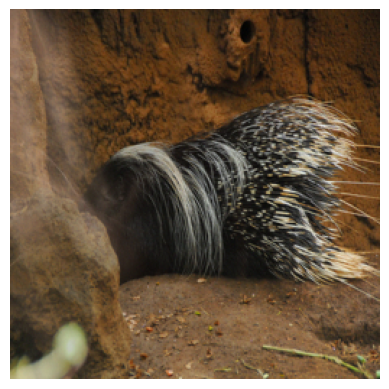

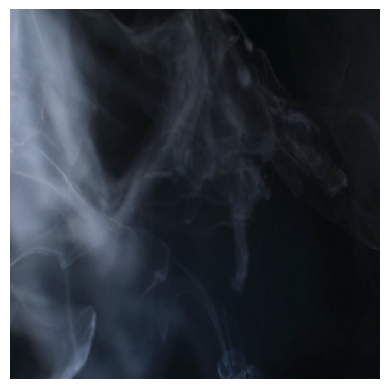

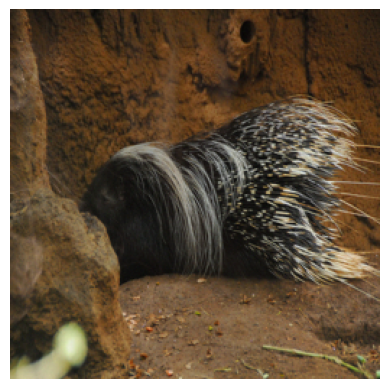

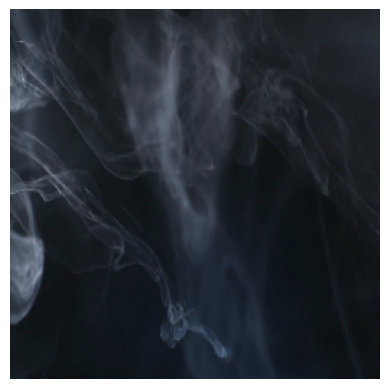

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.3114258e-05..0.96875197].


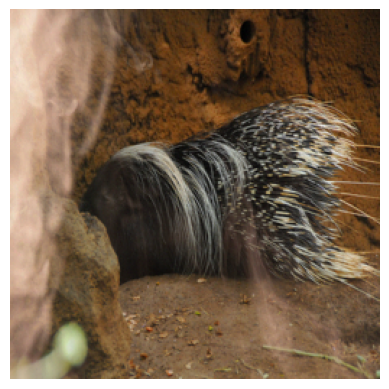

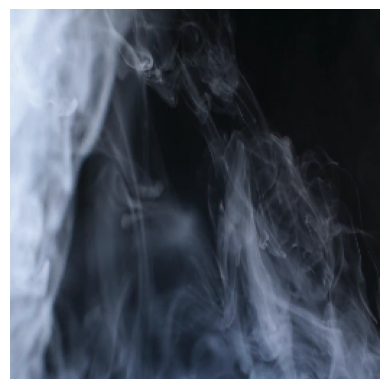

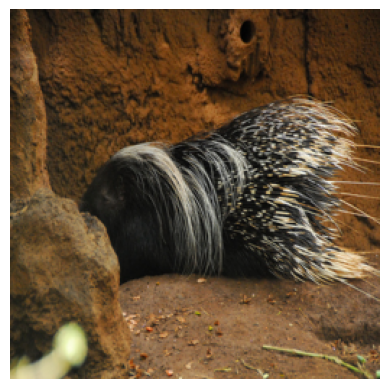

In [26]:
so = ["0100", "0140", "0190", "0750", "0640", "0350"]

dirs_ = "/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/observed"
os.makedirs(dirs_, exist_ok=True)
for ii, s in enumerate(so):
    im_name = f"{(ii):05d}"
    h_pth = f"/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/frame_{s}.jpg"
    im_pth = "/users/cmk2000/sharedscratch/Datasets/testsets/imagenet/ILSVRC2012_val_00000007.png"
    H = cv2.imread(h_pth)
    im = cv2.imread(im_pth)
    h = cv2.resize(H, (im_size, im_size)) 
    x = cv2.resize(im, (im_size, im_size)) 

    scale = h/255

    y = (1-scale)*x + scale*h  
    y = torch.from_numpy(y/255.).float().flip([2])

    y = y + 0.005 * torch.randn_like(y)
    plt.imshow(y)
    plt.axis("off")
    # plt.savefig(os.path.join("/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/observed", f"{im_name}_y.png"))
    plt.show()
    save_images(dirs_, y, f"{im_name}_y")
    
    plt.imshow(h)
    plt.axis("off")
    # plt.savefig(os.path.join("/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/observed", f"{im_name}_h.png"))
    plt.show()
    save_images(dirs_, h, f"{im_name}_h")
    
x = torch.from_numpy(x/255.).float().flip([2])
plt.imshow(x)
plt.axis("off")
# plt.savefig(os.path.join("/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/observed", f"true.png"))
plt.show()
save_images(dirs_, x, f"true")

In [2]:

h = cv2.resize(H, (im_size, im_size)) 
x = cv2.resize(im, (im_size, im_size)) 

scale = h/255
x.max(), h.max()

(255, 229)

(-0.5, 255.5, 255.5, -0.5)

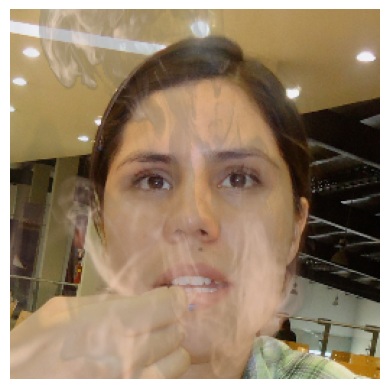

In [5]:
import torch
import matplotlib.pyplot as plt


y = (1-scale)*x + scale*h  
y = torch.from_numpy(y/255.).float().flip([2])

y = y + 0.001 * torch.randn_like(y)
plt.imshow(y)
plt.axis("off")

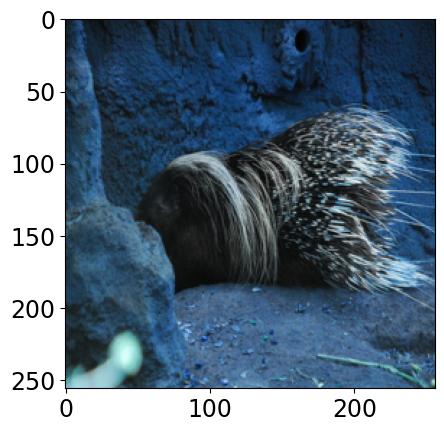

In [87]:
plt.imshow(im)

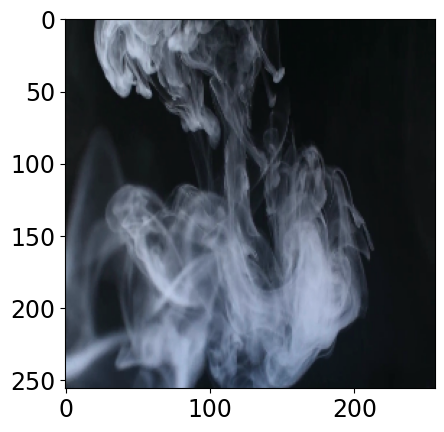

In [88]:
plt.imshow(h)